In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import trueskill.trueskill as ts 
%matplotlib inline

In [2]:
# Initialize TrueSkill module
# From http://trueskill.org
ts.backends.choose_backend('scipy')
ts.setup(draw_probability=0.01)
ts.Rating()

trueskill.trueskill.Rating(mu=25.000, sigma=8.333)

In [3]:
def create_player_skills(mu, sigma, n):
    return np.random.normal(mu, sigma, n)

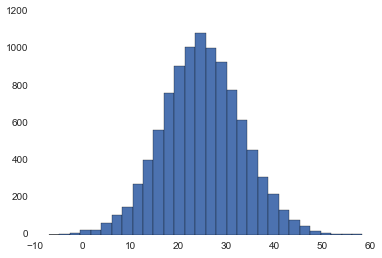

In [4]:
# Distribution of player skill
_ = plt.hist(create_player_skills(25, 25/3, 10000), bins=30)

In [24]:
# half of one std deviation (i.e. 25/6) in difference between players equals ~80% win chance  
player_uneveness = 25/6

In [25]:
def create_initial_player_ratings(n):
    return np.array([ts.Rating() for x in range(n)])

In [26]:
def simulate_round_with_teams(team1, team2, player_skills, ratings):
    
    # Simple simulation of game round between team 1 and team 2
    t1_skill_sum = (player_skills[team1] + np.random.normal(0, player_uneveness, len(team1))).sum()
    t2_skill_sum = (player_skills[team2] + np.random.normal(0, player_uneveness, len(team2))).sum()
    
    t1_skill_sum += random.uniform(-t1_skill_sum/2, t1_skill_sum/2) # Not playing the objective
    outcome = 0
    if t1_skill_sum > t2_skill_sum:
        outcome = 1
    if t1_skill_sum < t2_skill_sum:
        outcome = 2
    return outcome

In [27]:
def simulate_round(n_players, team_size, player_skills, ratings, player_round_count):
    
    # Create to random teams
    subset = np.random.choice(n_players, size=team_size*2, replace=False)
    team1 = subset[0:team_size//2]
    team2 = subset[team_size//2:team_size]
    
    # Simulate a round between the teams
    player_round_count[team1] += 1
    player_round_count[team2] += 1
    outcome = simulate_round_with_teams(team1, team2, player_skills, ratings)

    # Calculate new ratings according to outcome
    r1 = ratings[team1].tolist()
    r2 = ratings[team2].tolist()
    if outcome == 1:
        new_ratings = ts.rate([r1, r2], [0, 1]) # team1 won
    elif outcome == 2: 
        new_ratings = ts.rate([r1, r2], [1, 0]) # team2 won
    else:
        new_ratings = ts.rate([r1, r2], [0, 0]) # draw
    
    # Update player ratings
    for (p, i) in zip(team1, range(len(team1))):
        ratings[p] = new_ratings[0][i]
    for (p, i) in zip(team2, range(len(team2))):
        ratings[p] = new_ratings[1][i]
    
    return ratings, player_round_count


In [28]:
def estimate_skills(ratings):
    return np.array([r.mu for r in ratings])

In [29]:
def simulate(team_size = 4, player_rounds = 20):
    
    # Init simulation params
    n_players = team_size * 500 
    rounds = (n_players // team_size) * player_rounds
    ratings = create_initial_player_ratings(n_players)
    player_skills = create_player_skills(25, 25/3, n_players)
    print('Team size: %d  Players: %d  Simulated global rounds: %d' % (team_size, n_players, rounds))
    print('Player')
    print('rounds\tRMSE\tSigma')
    
    # Init statistics
    player_round_count = np.zeros(n_players)
    rmses = []
    skill_sigmas = []
    current_round_count = -1
    
    for i in range(rounds):
  
        # Simulate a round
        ratings, player_round_count = simulate_round(n_players, team_size, player_skills, ratings, player_round_count)
        
        # Sample statistics whenever the mean round count of players change
        round_count_mean = int(player_round_count.mean())
        if current_round_count != round_count_mean:
            current_round_count = round_count_mean
            estimated_skills = estimate_skills(ratings) 
            skill_sd_mean = np.array([r.sigma for r in ratings]).mean()
            rmse = math.sqrt(((player_skills - estimated_skills) ** 2).mean())
            rmses.append(rmse)
            skill_sigmas.append(skill_sd_mean)
            if current_round_count % (player_rounds//10) == 0: # Show progress every 10th player round
                print("%d \t%1.2f \t%1.2f" % (round_count_mean, rmse, skill_sd_mean))
            
    print()
    return (player_skills, ratings, rmses, skill_sigmas) 

In [30]:
def plot_results(players_skills, ratings, rmses, skill_sigmas):
    estimated_skills = estimate_skills(ratings) 

    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(6)
    
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Rounds', fontsize=16)
    ax1.set_ylim([0,10])
    ax1.plot(rmses, label='$\sqrt{MSE}$')
    ax1.plot(skill_sigmas, label='$\sigma_{TrueSkill}$')
    ax1.legend(loc='upper right', fontsize=16)
    
    ax2 = fig.add_subplot(122)
    ax2.set_ylabel('Estimated skill after last round', fontsize=14)
    ax2.set_xlabel('Actual skill', fontsize=16)
    ax2.set_ylim(0,50)
    ax2.set_xlim(0,50)
    ax2.scatter(player_skills, estimated_skills, alpha=200/len(player_skills))
    ax2.plot([0,50],[0,50], color = '#666666')
    
    plt.show()

In [31]:
def plot_summary(final_rmses, final_skill_sigmas):
    
    fig = plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(8)
    
    ax1 = fig.add_subplot(121)
    ax1.grid(True)
    ax1.set_ylabel('$\sqrt{MSE}$', fontsize=20)
    ax1.set_xlabel('Rounds', fontsize=16)
    ax1.set_ylim([0,10])
    
    ax2 = fig.add_subplot(122)
    ax2.set_ylabel('$\sigma_{TrueSkill}$', fontsize=20)
    ax2.set_xlabel('Rounds', fontsize=16)
    ax2.grid(True)
    ax2.set_ylim([0,10])
    
    for team_size in sorted(final_rmses.keys()):
        ax1.plot(final_rmses[team_size], label=str(team_size))
    for team_size in sorted(final_skill_sigmas.keys()):
        ax2.plot(final_skill_sigmas[team_size], label=str(team_size)) 
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
      
    plt.show()

Simulating team sizes [2, 4, 8, 16, 32] with player uneveness = 4.17
Team size: 2  Players: 1000  Simulated global rounds: 100000
Player
rounds	RMSE	Sigma
0 	8.29 	8.33
20 	3.70 	2.40
40 	3.26 	1.64
60 	3.14 	1.34
80 	3.09 	1.18
100 	3.06 	1.08
120 	3.09 	1.02
140 	3.10 	0.98
160 	3.12 	0.95
180 	3.11 	0.93
200 	3.12 	0.91



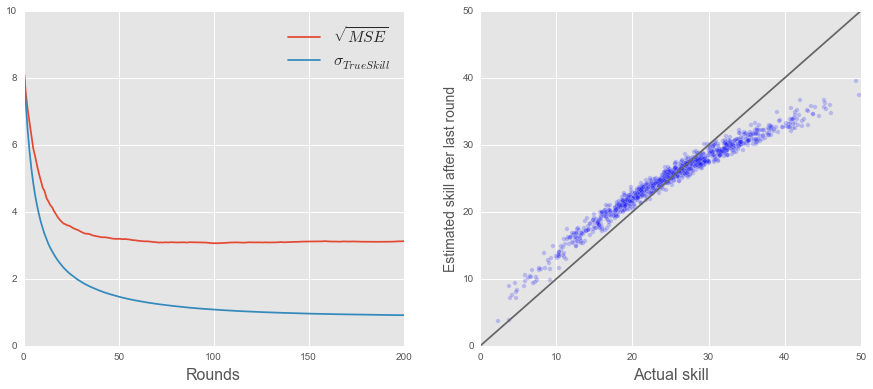

Team size: 4  Players: 2000  Simulated global rounds: 100000
Player
rounds	RMSE	Sigma
0 	8.34 	8.33
20 	5.30 	3.53
40 	4.46 	2.37
60 	4.22 	1.88
80 	4.13 	1.61
100 	4.11 	1.44
120 	4.11 	1.32
140 	4.11 	1.24
160 	4.15 	1.18
180 	4.16 	1.14
200 	4.17 	1.11



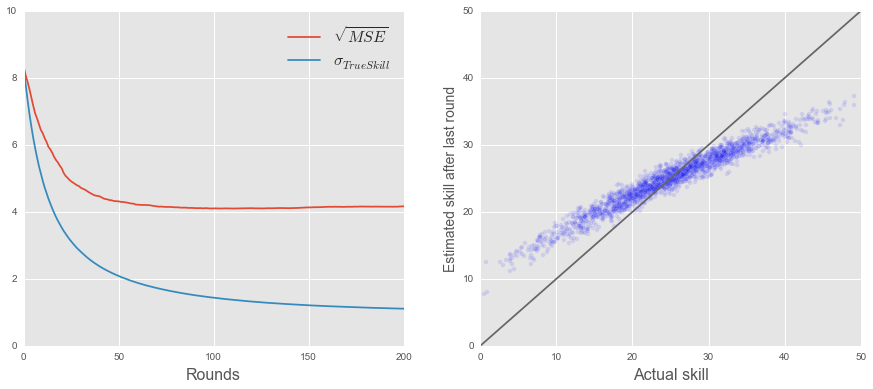

Team size: 8  Players: 4000  Simulated global rounds: 100000
Player
rounds	RMSE	Sigma
0 	8.35 	8.33
20 	6.91 	4.93
40 	6.00 	3.50
60 	5.59 	2.77
80 	5.41 	2.33
100 	5.29 	2.05
120 	5.25 	1.85
140 	5.23 	1.70
160 	5.21 	1.59
180 	5.22 	1.51
200 	5.22 	1.45



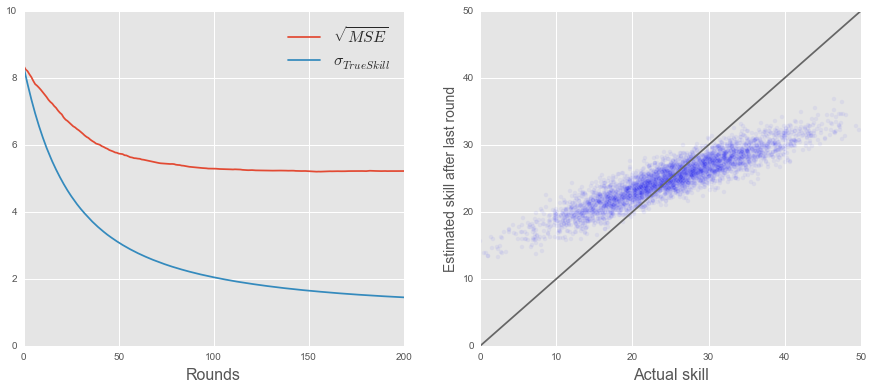

Team size: 16  Players: 8000  Simulated global rounds: 100000
Player
rounds	RMSE	Sigma
0 	8.38 	8.33
20 	8.11 	6.23
40 	7.62 	4.92
60 	7.17 	4.06
80 	6.91 	3.47
100 	6.71 	3.04
120 	6.55 	2.73
140 	6.47 	2.49
160 	6.39 	2.30
180 	6.35 	2.16
200 	6.31 	2.03



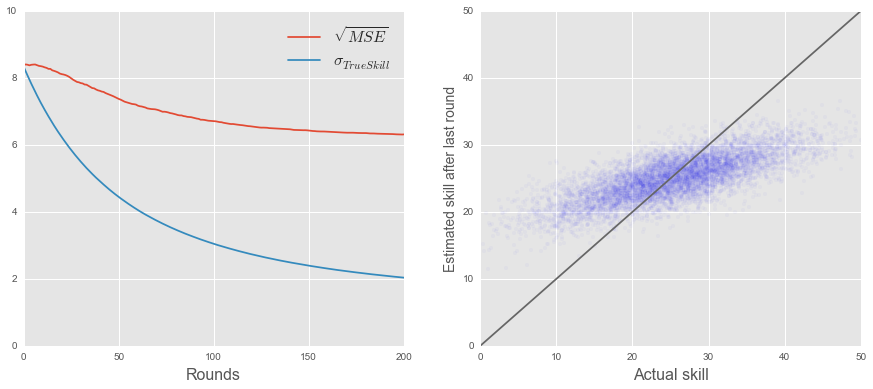

Team size: 32  Players: 16000  Simulated global rounds: 100000
Player
rounds	RMSE	Sigma
0 	8.41 	8.33
20 	8.63 	7.16
40 	8.53 	6.24
60 	8.37 	5.51
80 	8.19 	4.93
100 	7.98 	4.45
120 	7.84 	4.06
140 	7.68 	3.74
160 	7.57 	3.47
180 	7.45 	3.25
200 	7.37 	3.06



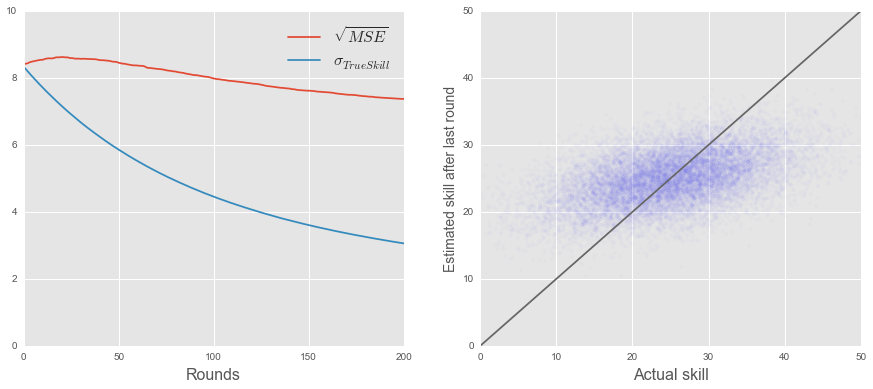

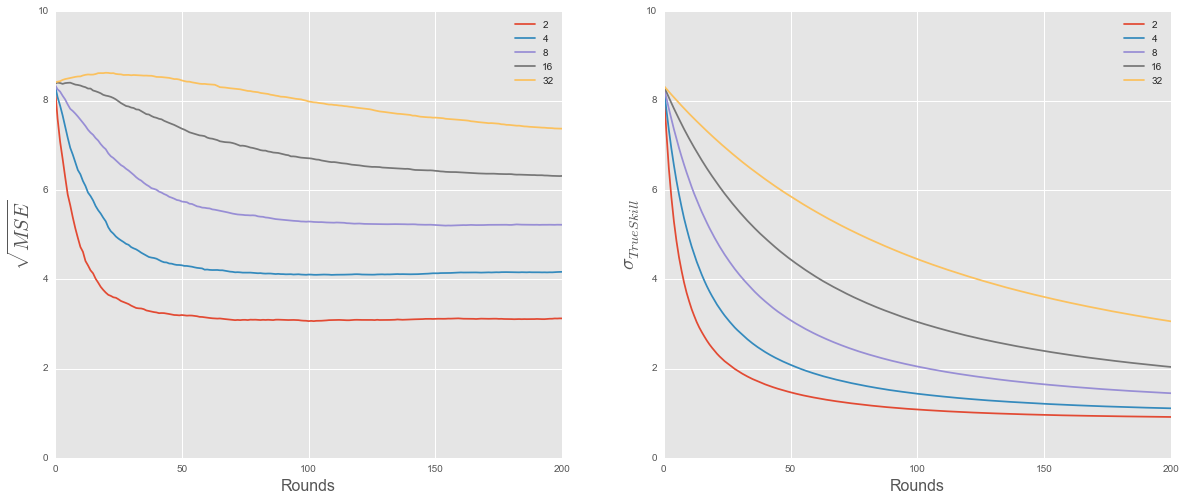

In [32]:
# Run the simulation
final_rmses = {}
final_skill_sigmas = {}
plt.style.use('ggplot')
team_sizes = [2, 4, 8, 16, 32]

print('Simulating team sizes %r with player uneveness = %.2f' % (team_sizes, player_uneveness))

# Simulate different team sizes
for team_size in team_sizes:
    player_skills, ratings, rmses, skill_sigmas = simulate(team_size = team_size, player_rounds = 200)
    
    # Save simulation results for this team size
    final_rmses[team_size] = rmses
    final_skill_sigmas[team_size] = skill_sigmas
    
    # Plot results for this team size
    plot_results(player_skills, ratings, rmses, skill_sigmas)

# Summary plots containing all team sizes
plot_summary(final_rmses, final_skill_sigmas)
